# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Exclude train middle.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-09 13:36:54.089437


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = True
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_245'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-09 13:37:47.761245
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-09 13:37:48.124454
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4371
Num RCI: 4371
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4371 sequences.

Training # 1 1
2023-04-09 13:37:58.915292
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-09 13:37:59.310729
Discriminator ZERO -1
Train 1:0 939:1175 44.42%
Valid 1:0 402:473 45.94%
FIT
2023-04-09 13:37:59.391278


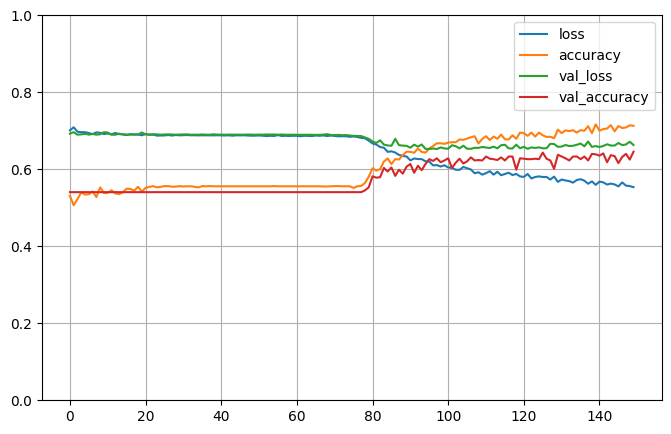


Testing # 1 1
2023-04-09 13:39:22.857757
2023-04-09 13:39:22.857818
PREDICT
2023-04-09 13:39:22.874011
Test 1:0 402:473 45.94%
Predict 1:0 444:431 50.74%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.48541173 mean 0.22400492 std
Range of scores: 0.008738993 to 0.8961235
Score threshold 0.5
Confusion matrix
 [[297 176]
 [134 268]]
Normalized matrix
 [[0.33942857 0.20114286]
 [0.15314286 0.30628571]]
Extreme scores correct, pos:neg 154 181
Extreme scores incorrect pos:neg 90 69


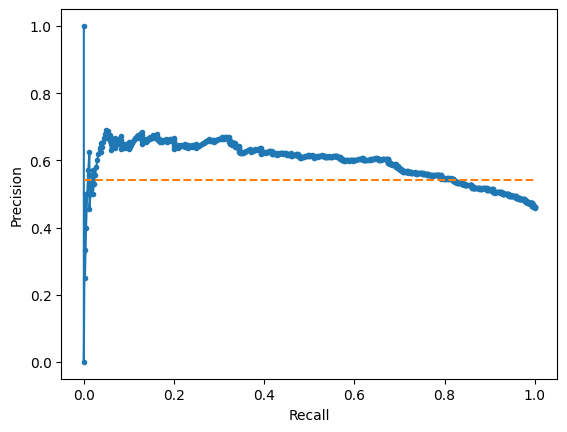

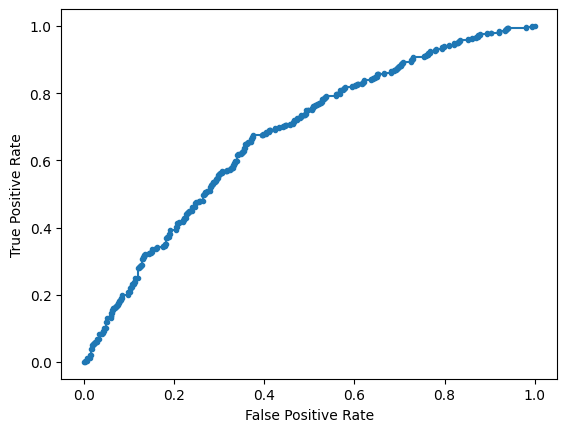

Accuracy: 64.57% Precision: 60.36% Recall: 66.67%
F1: 63.36% MCC: 0.2936
AUPRC: 59.60% AUROC: 67.33%
 accuracy [64.57142857142857]
 precision [60.36036036036037]
 recall [66.66666666666666]
 F1 [63.35697399527188]
 MCC [0.29363469085819305]
 AUPRC [59.604253625150605]
 AUROC [67.33457448486952]

Training # 1 2
2023-04-09 13:39:23.560251
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-09 13:39:23.921915
Discriminator ZERO -1
Train 1:0 926:1181 43.95%
Valid 1:0 418:457 47.77%
FIT
2023-04-09 13:39:24.021176


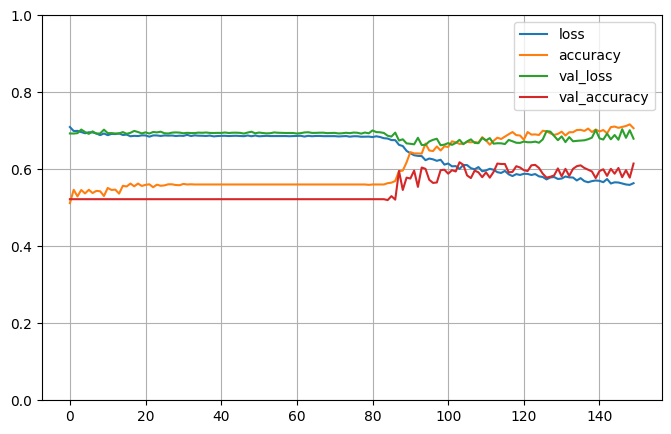


Testing # 1 2
2023-04-09 13:40:20.029005
2023-04-09 13:40:20.029602
PREDICT
2023-04-09 13:40:20.039941
Test 1:0 418:457 47.77%
Predict 1:0 527:348 60.23%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5251661 mean 0.20557418 std
Range of scores: 0.008277729 to 0.8862299
Score threshold 0.5
Confusion matrix
 [[234 223]
 [114 304]]
Normalized matrix
 [[0.26742857 0.25485714]
 [0.13028571 0.34742857]]
Extreme scores correct, pos:neg 167 134
Extreme scores incorrect pos:neg 124 50


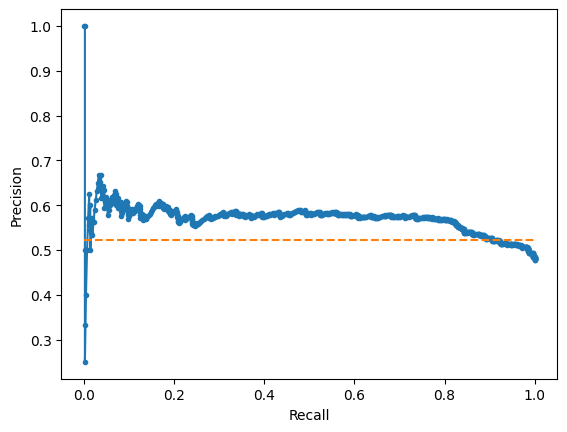

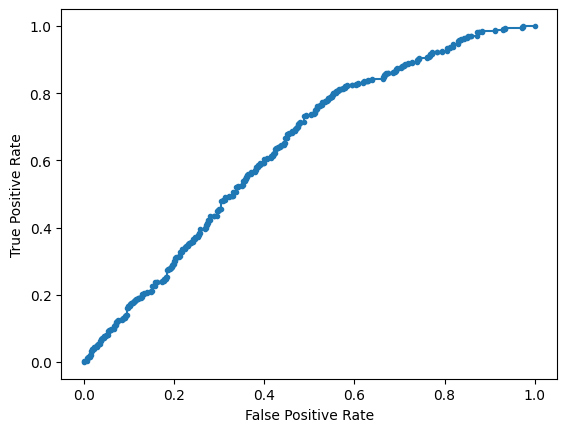

Accuracy: 61.49% Precision: 57.69% Recall: 72.73%
F1: 64.34% MCC: 0.2442
AUPRC: 57.02% AUROC: 63.69%
 accuracy [61.48571428571429]
 precision [57.685009487666036]
 recall [72.72727272727273]
 F1 [64.33862433862434]
 MCC [0.2442350860356871]
 AUPRC [57.023678979593214]
 AUROC [63.69185346497335]

Training # 1 3
2023-04-09 13:40:20.655777
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-09 13:40:20.977505
Discriminator ZERO -1
Train 1:0 951:1183 44.56%
Valid 1:0 390:484 44.62%
FIT
2023-04-09 13:40:21.077034


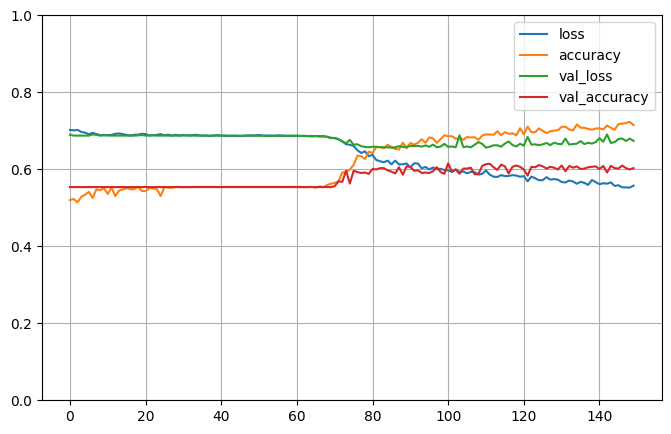


Testing # 1 3
2023-04-09 13:41:16.546017
2023-04-09 13:41:16.546070
PREDICT
2023-04-09 13:41:16.559009
Test 1:0 390:484 44.62%
Predict 1:0 423:451 48.40%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.47824222 mean 0.21443695 std
Range of scores: 0.0100425985 to 0.9020637
Score threshold 0.5
Confusion matrix
 [[294 190]
 [157 233]]
Normalized matrix
 [[0.33638444 0.2173913 ]
 [0.17963387 0.26659039]]
Extreme scores correct, pos:neg 126 197
Extreme scores incorrect pos:neg 91 72


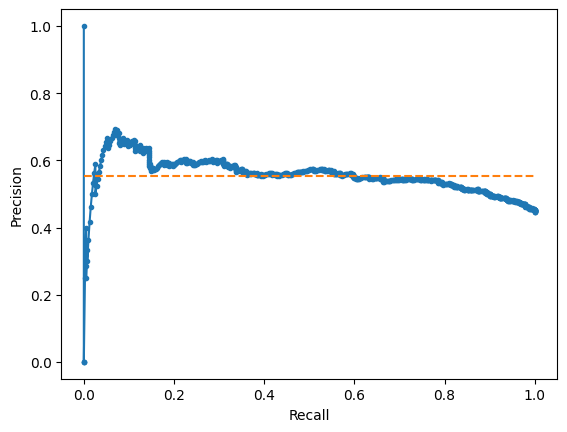

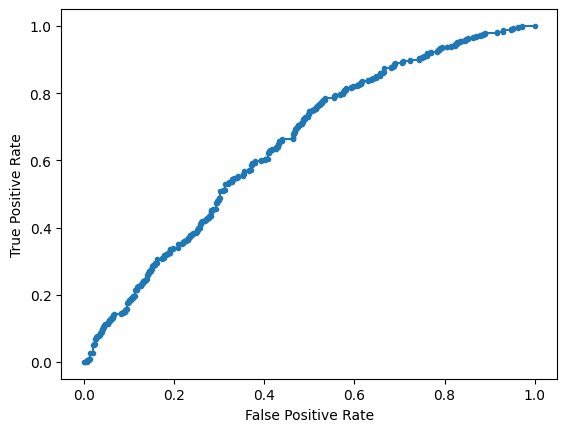

Accuracy: 60.30% Precision: 55.08% Recall: 59.74%
F1: 57.32% MCC: 0.2038
AUPRC: 55.60% AUROC: 64.90%
 accuracy [60.297482837528605]
 precision [55.08274231678487]
 recall [59.743589743589745]
 F1 [57.31857318573185]
 MCC [0.20379015240633244]
 AUPRC [55.602352019310274]
 AUROC [64.89616444161899]

Training # 1 4
2023-04-09 13:41:17.176928
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-09 13:41:17.514107
Discriminator ZERO -1
Train 1:0 936:1202 43.78%
Valid 1:0 424:450 48.51%
FIT
2023-04-09 13:41:17.607973


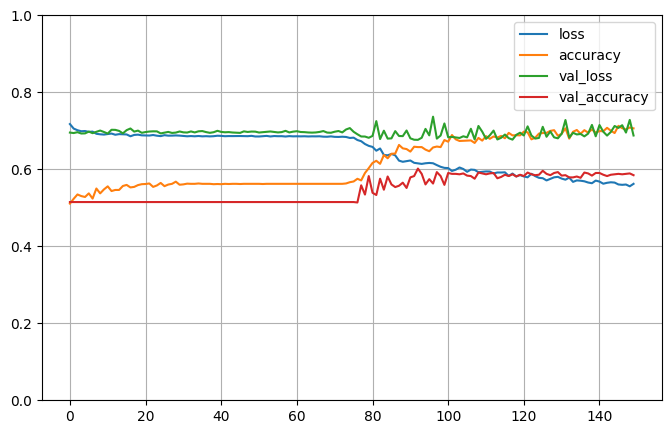


Testing # 1 4
2023-04-09 13:42:12.050760
2023-04-09 13:42:12.050812
PREDICT
2023-04-09 13:42:12.061207
Test 1:0 424:450 48.51%
Predict 1:0 467:407 53.43%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.503495 mean 0.20867024 std
Range of scores: 0.0061447658 to 0.87528646
Score threshold 0.5
Confusion matrix
 [[247 203]
 [160 264]]
Normalized matrix
 [[0.2826087  0.23226545]
 [0.18306636 0.3020595 ]]
Extreme scores correct, pos:neg 162 154
Extreme scores incorrect pos:neg 98 61


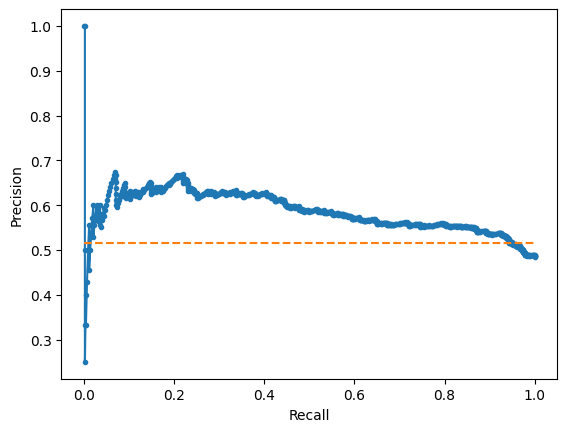

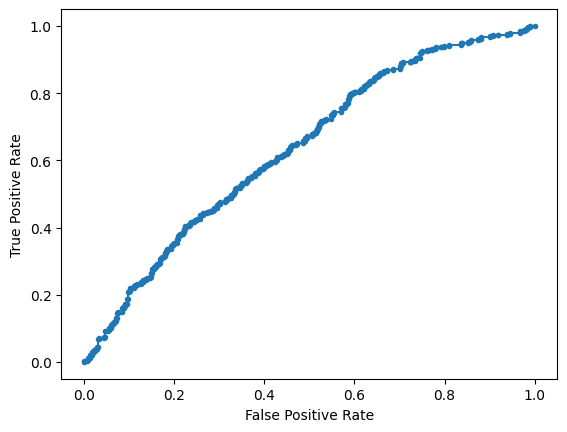

Accuracy: 58.47% Precision: 56.53% Recall: 62.26%
F1: 59.26% MCC: 0.1719
AUPRC: 58.61% AUROC: 63.56%
 accuracy [58.46681922196796]
 precision [56.53104925053534]
 recall [62.264150943396224]
 F1 [59.25925925925927]
 MCC [0.17185993231336252]
 AUPRC [58.60877453565203]
 AUROC [63.55503144654089]

Training # 1 5
2023-04-09 13:42:12.666580
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-09 13:42:12.964013
Discriminator ZERO -1
Train 1:0 916:1203 43.23%
Valid 1:0 427:446 48.91%
FIT
2023-04-09 13:42:13.044738


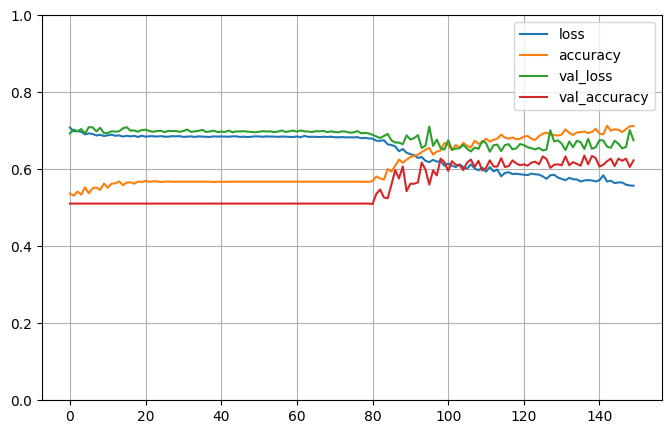


Testing # 1 5
2023-04-09 13:43:07.667545
2023-04-09 13:43:07.667591
PREDICT
2023-04-09 13:43:07.675017
Test 1:0 427:446 48.91%
Predict 1:0 340:533 38.95%
Test sizes (873, 1025) (873,)
Distrib of scores: 0.42424786 mean 0.21981245 std
Range of scores: 0.009941354 to 0.85407716
Score threshold 0.5
Confusion matrix
 [[325 121]
 [208 219]]
Normalized matrix
 [[0.3722795  0.13860252]
 [0.23825888 0.25085911]]
Extreme scores correct, pos:neg 117 229
Extreme scores incorrect pos:neg 57 115


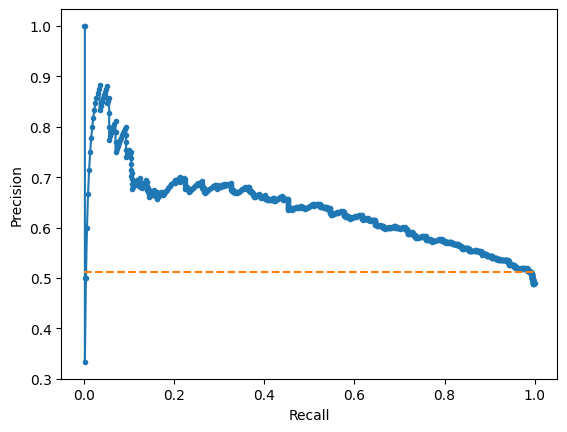

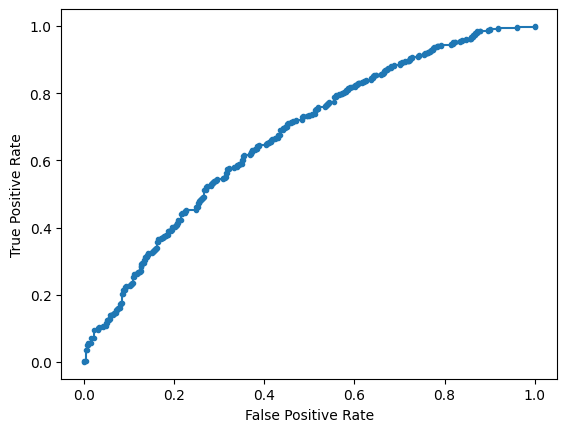

Accuracy: 62.31% Precision: 64.41% Recall: 51.29%
F1: 57.11% MCC: 0.2477
AUPRC: 63.86% AUROC: 67.22%
 accuracy [62.31386025200458]
 precision [64.41176470588236]
 recall [51.288056206088996]
 F1 [57.10560625814863]
 MCC [0.24765065732403252]
 AUPRC [63.86464872994713]
 AUROC [67.21574022537047]

Training # 2 1
2023-04-09 13:43:08.259368
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-09 13:43:08.568567
Discriminator ZERO -1
Train 1:0 941:1187 44.22%
Valid 1:0 406:469 46.40%
FIT
2023-04-09 13:43:08.647644


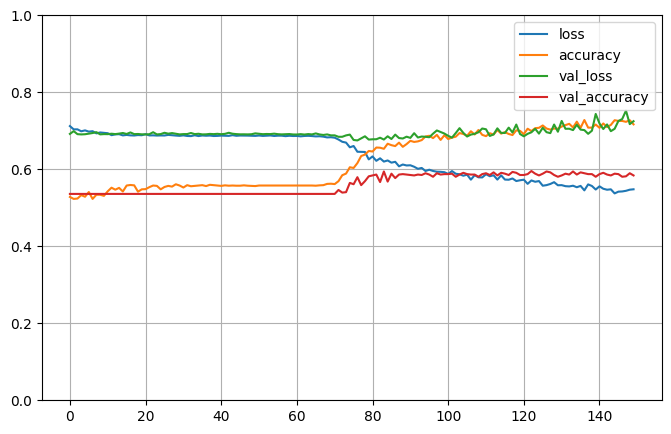


Testing # 2 1
2023-04-09 13:44:32.110808
2023-04-09 13:44:32.111212
PREDICT
2023-04-09 13:44:32.119384
Test 1:0 406:469 46.40%
Predict 1:0 286:589 32.69%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.39039558 mean 0.22320057 std
Range of scores: 0.005574543 to 0.9255697
Score threshold 0.5
Confusion matrix
 [[347 122]
 [242 164]]
Normalized matrix
 [[0.39657143 0.13942857]
 [0.27657143 0.18742857]]
Extreme scores correct, pos:neg 83 266
Extreme scores incorrect pos:neg 55 152


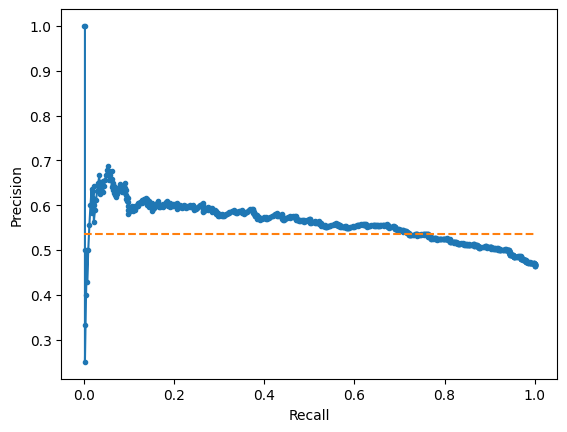

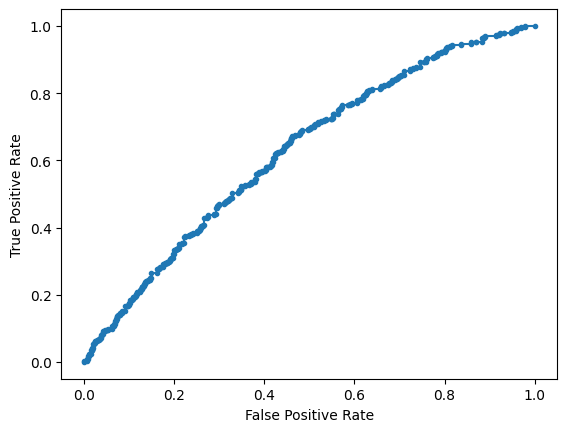

Accuracy: 58.40% Precision: 57.34% Recall: 40.39%
F1: 47.40% MCC: 0.1529
AUPRC: 56.15% AUROC: 62.63%
 accuracy [58.4]
 precision [57.34265734265735]
 recall [40.39408866995074]
 F1 [47.398843930635834]
 MCC [0.15289975306630432]
 AUPRC [56.150464541366176]
 AUROC [62.63194933145672]

Training # 2 2
2023-04-09 13:44:33.023754
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-09 13:44:33.353902
Discriminator ZERO -1
Train 1:0 929:1189 43.86%
Valid 1:0 416:459 47.54%
FIT
2023-04-09 13:44:33.482956


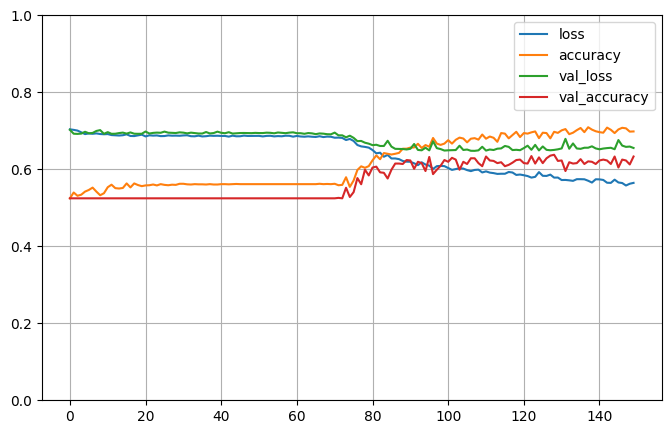


Testing # 2 2
2023-04-09 13:45:56.881173
2023-04-09 13:45:56.881245
PREDICT
2023-04-09 13:45:56.891807
Test 1:0 416:459 47.54%
Predict 1:0 431:444 49.26%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.47655448 mean 0.2124818 std
Range of scores: 0.011331262 to 0.8784875
Score threshold 0.5
Confusion matrix
 [[291 168]
 [153 263]]
Normalized matrix
 [[0.33257143 0.192     ]
 [0.17485714 0.30057143]]
Extreme scores correct, pos:neg 140 192
Extreme scores incorrect pos:neg 83 69


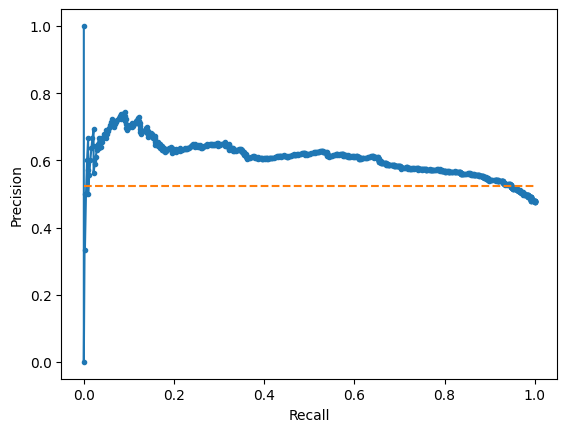

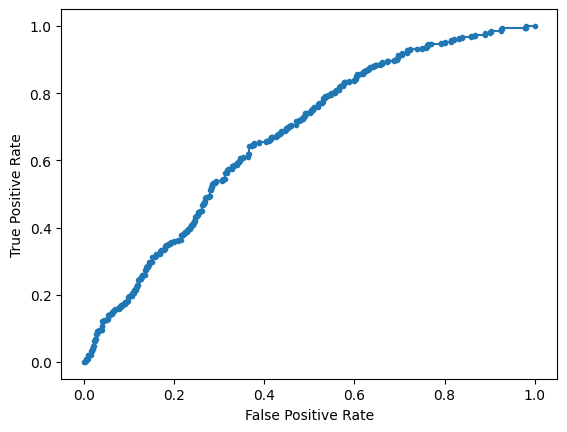

Accuracy: 63.31% Precision: 61.02% Recall: 63.22%
F1: 62.10% MCC: 0.2659
AUPRC: 60.74% AUROC: 67.12%
 accuracy [63.31428571428571]
 precision [61.02088167053365]
 recall [63.22115384615385]
 F1 [62.10153482880756]
 MCC [0.2659061838770031]
 AUPRC [60.74184765113164]
 AUROC [67.12439249203956]

Training # 2 3
2023-04-09 13:45:57.496715
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-09 13:45:57.806740
Discriminator ZERO -1
Train 1:0 924:1198 43.54%
Valid 1:0 427:447 48.86%
FIT
2023-04-09 13:45:57.889664


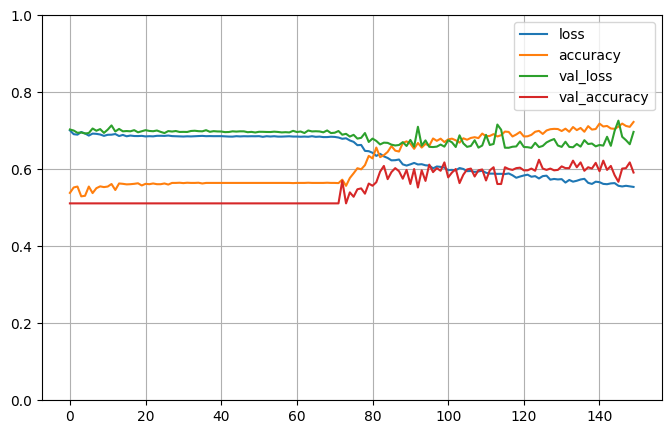


Testing # 2 3
2023-04-09 13:46:54.008441
2023-04-09 13:46:54.008496
PREDICT
2023-04-09 13:46:54.034178
Test 1:0 427:447 48.86%
Predict 1:0 316:558 36.16%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.40603793 mean 0.22742127 std
Range of scores: 0.0105465725 to 0.8722422
Score threshold 0.5
Confusion matrix
 [[324 123]
 [234 193]]
Normalized matrix
 [[0.37070938 0.14073227]
 [0.26773455 0.2208238 ]]
Extreme scores correct, pos:neg 103 251
Extreme scores incorrect pos:neg 59 136


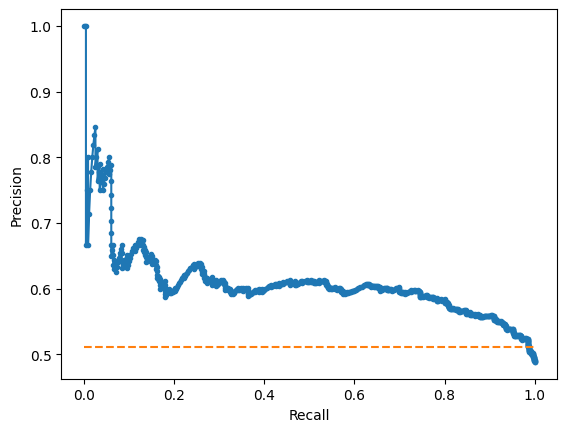

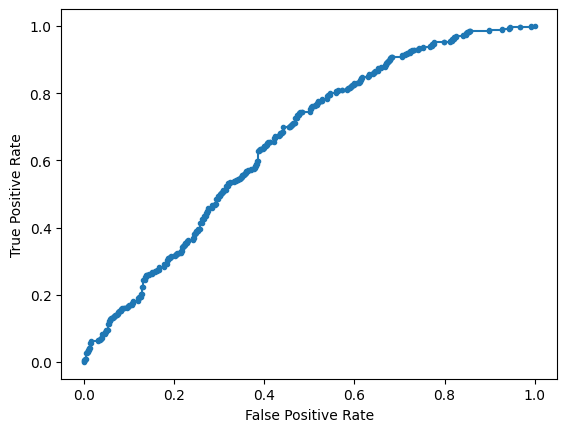

Accuracy: 59.15% Precision: 61.08% Recall: 45.20%
F1: 51.95% MCC: 0.1840
AUPRC: 60.87% AUROC: 65.65%
 accuracy [59.153318077803206]
 precision [61.07594936708861]
 recall [45.19906323185012]
 F1 [51.95154777927322]
 MCC [0.18396933449707145]
 AUPRC [60.87482728404474]
 AUROC [65.65445410202808]

Training # 2 4
2023-04-09 13:46:54.671012
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-09 13:46:54.971936
Discriminator ZERO -1
Train 1:0 953:1173 44.83%
Valid 1:0 392:481 44.90%
FIT
2023-04-09 13:46:55.066271


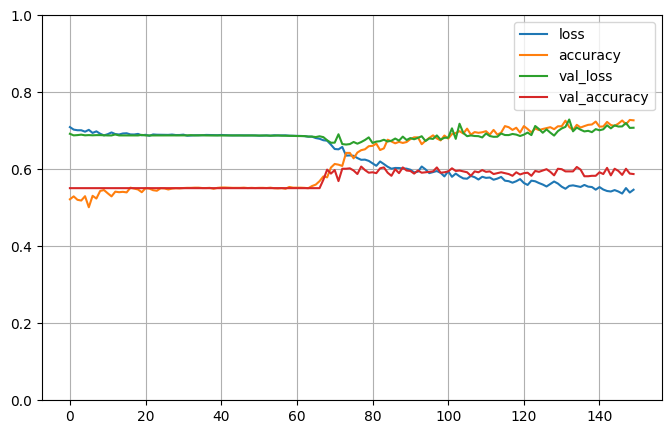


Testing # 2 4
2023-04-09 13:47:52.939319
2023-04-09 13:47:52.939365
PREDICT
2023-04-09 13:47:52.946233
Test 1:0 392:481 44.90%
Predict 1:0 376:497 43.07%
Test sizes (873, 1025) (873,)
Distrib of scores: 0.4489955 mean 0.23899022 std
Range of scores: 0.0059502483 to 0.91519845
Score threshold 0.5
Confusion matrix
 [[309 172]
 [188 204]]
Normalized matrix
 [[0.35395189 0.19702176]
 [0.21534937 0.23367698]]
Extreme scores correct, pos:neg 130 221
Extreme scores incorrect pos:neg 93 104


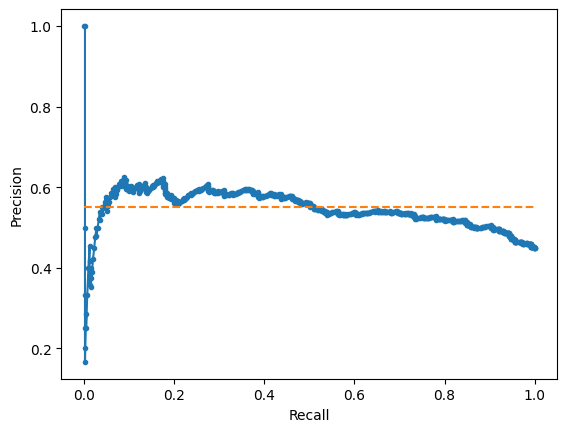

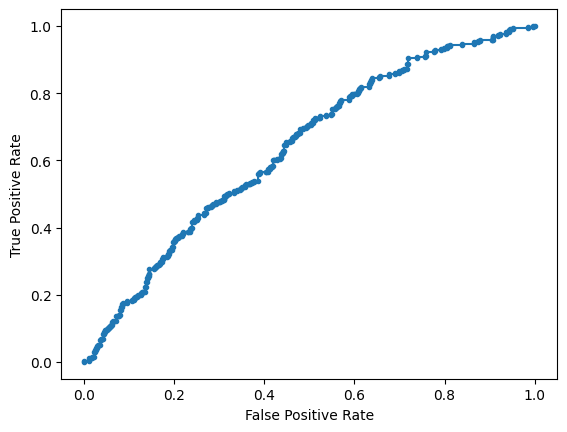

Accuracy: 58.76% Precision: 54.26% Recall: 52.04%
F1: 53.12% MCC: 0.1636
AUPRC: 54.66% AUROC: 63.53%
 accuracy [58.76288659793815]
 precision [54.25531914893617]
 recall [52.04081632653062]
 F1 [53.125]
 MCC [0.16355005215310367]
 AUPRC [54.664264951911825]
 AUROC [63.533136747422446]

Training # 2 5
2023-04-09 13:47:53.560407
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-09 13:47:53.849393
Discriminator ZERO -1
Train 1:0 921:1197 43.48%
Valid 1:0 420:454 48.05%
FIT
2023-04-09 13:47:53.937675


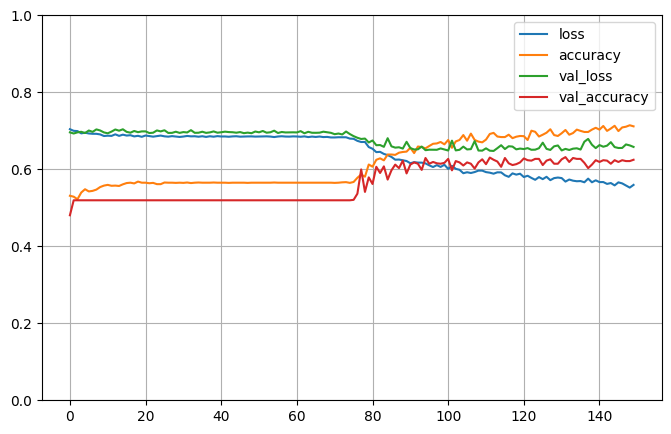


Testing # 2 5
2023-04-09 13:48:50.049822
2023-04-09 13:48:50.050154
PREDICT
2023-04-09 13:48:50.060247
Test 1:0 420:454 48.05%
Predict 1:0 382:492 43.71%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.45684934 mean 0.20919465 std
Range of scores: 0.010825952 to 0.86237866
Score threshold 0.5
Confusion matrix
 [[309 145]
 [183 237]]
Normalized matrix
 [[0.35354691 0.16590389]
 [0.20938215 0.27116705]]
Extreme scores correct, pos:neg 124 204
Extreme scores incorrect pos:neg 59 81


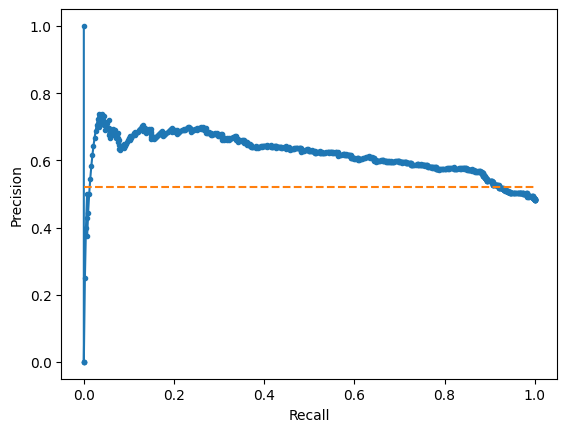

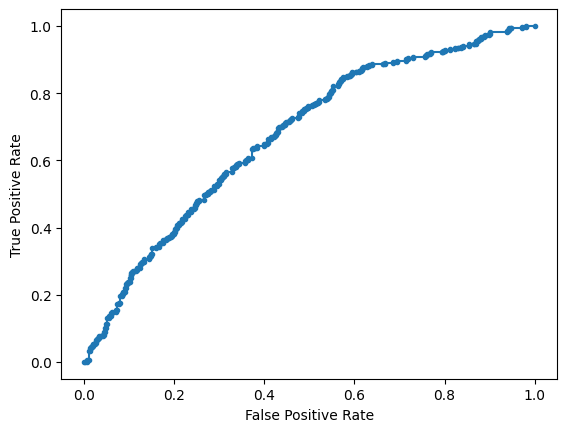

Accuracy: 62.47% Precision: 62.04% Recall: 56.43%
F1: 59.10% MCC: 0.2467
AUPRC: 61.80% AUROC: 67.45%
 accuracy [62.47139588100686]
 precision [62.04188481675392]
 recall [56.42857142857143]
 F1 [59.10224438902743]
 MCC [0.24667860079491427]
 AUPRC [61.797765211637255]
 AUROC [67.45122718691002]
2023-04-09 13:48:50.717851


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 60.92% std 2.22
 precision mean 58.98% std 3.29
 recall mean 57.00% std 9.93
 F1 mean 57.51% std 5.38
 MCC mean 0.2174 std 0.0484
 AUPRC mean 58.89% std 3.00
 AUROC mean 65.31% std 1.88
 accuracy [[64.57142857142857], [61.48571428571429], [60.297482837528605], [58.46681922196796], [62.31386025200458], [58.4], [63.31428571428571], [59.153318077803206], [58.76288659793815], [62.47139588100686]]
 precision [[60.36036036036037], [57.685009487666036], [55.08274231678487], [56.53104925053534], [64.41176470588236], [57.34265734265735], [61.02088167053365], [61.07594936708861], [54.25531914893617], [62.04188481675392]]
 recall [[66.66666666666666], [72.72727272727273], [59.743589743589745], [62.264150943396224], [51.288056206088996], [40.39408866995074], [63.22115384615385], [45.19906323185012], [52.04081632653062], [56.42857142857143]]
 F1 [[63.35697399527188], [64.33862433862434], [57.31857318573185], [59.25925925925927], [57.10560625814863], [47.398843930635834], [62.10153482